---
title: "Extracting and Combining Tensor Patches"
description: "In this tutorial we will show how you can extract and combine tensor patches using kornia"
author:
    - "Ashwin Nair"
date: 03-07-2022
categories:
    - Basic
    - Patches
    - kornia.contrib
image: "../tutorials/assets/extract_combine_patches.png"
---

<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/extract_combine_patches.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>

## Install and get data

In [1]:
%%capture
%matplotlib inline
# Install latest kornia
!pip install kornia
!pip install kornia-rs

In [2]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url = "https://raw.githubusercontent.com/kornia/data/main/panda.jpg"
download_image(url)

'panda.jpg'

In [3]:
import kornia as K
import matplotlib.pyplot as plt
import torch
from kornia.contrib import (
    CombineTensorPatches,
    ExtractTensorPatches,
    combine_tensor_patches,
    compute_padding,
    extract_tensor_patches,
)

## Using Modules

In [4]:
h, w = 8, 8
win = 4
pad = 2

image = torch.randn(2, 3, h, w)
print(image.shape)
tiler = ExtractTensorPatches(window_size=win, stride=win, padding=pad)
merger = CombineTensorPatches(original_size=(h, w), window_size=win, stride=win, unpadding=pad)
image_tiles = tiler(image)
print(image_tiles.shape)
new_image = merger(image_tiles)
print(new_image.shape)
assert torch.allclose(image, new_image)

torch.Size([2, 3, 8, 8])
torch.Size([2, 9, 3, 4, 4])
torch.Size([2, 3, 8, 8])


## Using Functions

In [5]:
h, w = 8, 8
win = 4
pad = 2

image = torch.randn(1, 1, h, w)
print(image.shape)
patches = extract_tensor_patches(image, window_size=win, stride=win, padding=pad)
print(patches.shape)
restored_img = combine_tensor_patches(patches, original_size=(h, w), window_size=win, stride=win, unpadding=pad)
print(restored_img.shape)
assert torch.allclose(image, restored_img)

torch.Size([1, 1, 8, 8])
torch.Size([1, 9, 1, 4, 4])
torch.Size([1, 1, 8, 8])


## Padding

All parameters of extract and combine functions accept a **single int** or **tuple of two ints**. Since padding is an integral part of these functions, it's important to note the following:

- If padding is `p` -> it means both height and width are padded by `2*p`
- If padding is `(ph, pw)` -> it means height is padded by `2*ph` and width is padded by `2*pw` 

It is recommended to use the existing function `compute_padding` to ensure the required padding is added.

### Examples

In [6]:
def extract_and_combine(image, window_size, padding):
    h, w = image.shape[-2:]
    tiler = ExtractTensorPatches(window_size=window_size, stride=window_size, padding=padding)
    merger = CombineTensorPatches(original_size=(h, w), window_size=window_size, stride=window_size, unpadding=padding)
    image_tiles = tiler(image)
    print(f"Shape of tensor patches = {image_tiles.shape}")
    merged_image = merger(image_tiles)
    print(f"Shape of merged image = {merged_image.shape}")
    assert torch.allclose(image, merged_image)
    return merged_image

In [7]:
image = torch.randn(2, 3, 9, 9)
_ = extract_and_combine(image, window_size=(4, 4), padding=(2, 2))

Shape of tensor patches = torch.Size([2, 9, 3, 4, 4])
Shape of merged image = torch.Size([2, 3, 9, 9])


These functions also work with rectangular images

In [8]:
rect_image = torch.randn(1, 1, 8, 6)
print(rect_image.shape)

torch.Size([1, 1, 8, 6])


In [9]:
restored_image = extract_and_combine(rect_image, window_size=(4, 4), padding=compute_padding((8, 6), 4))

Shape of tensor patches = torch.Size([1, 4, 1, 4, 4])
Shape of merged image = torch.Size([1, 1, 8, 6])


Recall that when padding is a tuple of ints `(ph, pw)`, the height and width are padded by `2*ph` and `2*pw` respectively.

In [10]:
# Confirm that the original image and restored image are the same
assert (restored_image == rect_image).all()

Let's now visualize how extraction and combining works.

Shape of image = torch.Size([1, 3, 510, 1020])


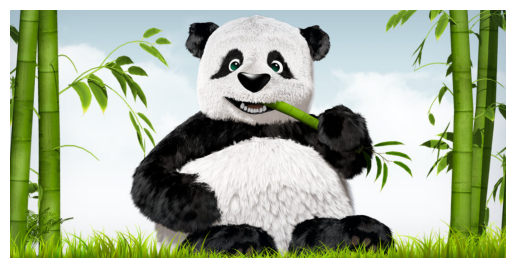

In [11]:
# Load sample image
img_tensor = K.io.load_image("panda.jpg", K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
h, w = img_tensor.shape[-2:]
print(f"Shape of image = {img_tensor.shape}")

plt.axis("off")
plt.imshow(K.tensor_to_image(img_tensor))
plt.show()

We will use `window_size = (400, 400)` with `stride = 200` to extract 15 overlapping tiles of shape `(400, 400)` and visualize them.

In [12]:
# Set window size
win = 400
# Set stride
stride = 200
# Calculate required padding
pad = compute_padding(original_size=(510, 1020), window_size=win)

tiler = ExtractTensorPatches(window_size=win, stride=stride, padding=pad)
image_tiles = tiler(img_tensor)
print(f"Shape of image tiles = {image_tiles.shape}")

Shape of image tiles = torch.Size([1, 15, 3, 400, 400])


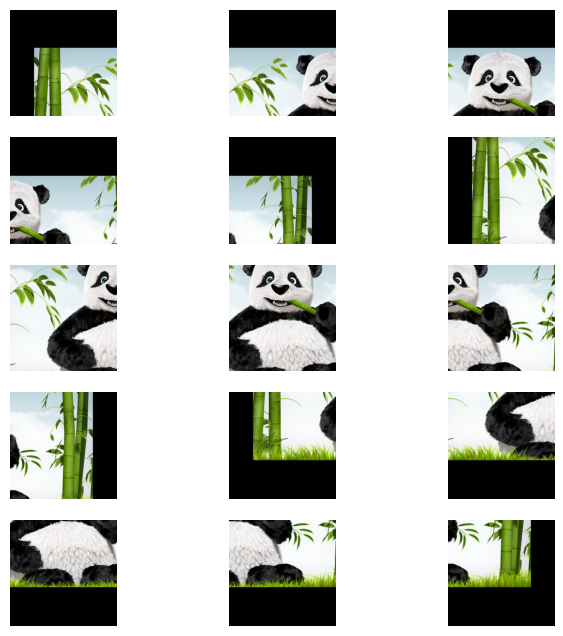

In [13]:
# Create the plot
fig, axs = plt.subplots(5, 3, figsize=(8, 8))
axs = axs.ravel()

for i in range(len(image_tiles[0])):
    axs[i].axis("off")
    axs[i].imshow(K.tensor_to_image(image_tiles[0][i]))

plt.show()

Finally, let's combine the patches and visualize the resulting image

Shape of restored image = torch.Size([1, 3, 510, 1020])


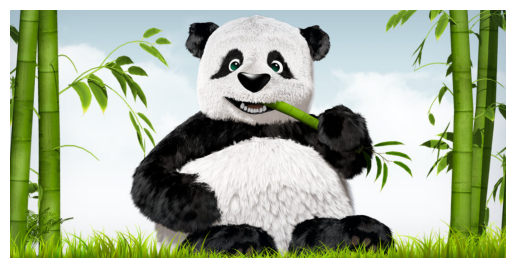

In [14]:
merger = CombineTensorPatches(original_size=(h, w), window_size=win, stride=stride, unpadding=pad)
merged_image = merger(image_tiles)
print(f"Shape of restored image = {merged_image.shape}")

plt.imshow(K.tensor_to_image(merged_image[0]))
plt.axis("off")
plt.show()